In [146]:
import matplotlib.pyplot as plt;
import os;

PATHDATA = "./data/";
     
    
def generate(dataFolderName):
    global XAXEDISPLAY;
    path = PATHDATA+dataFolderName;
    reader = datas();
    for fichier in os.listdir(path):
        if("sortieParticuliere" in fichier):
            reader.readFileBenchParticulier(path+"/"+fichier);
        elif("sortieIA" in fichier):
            reader.readFileIA(path+"/"+fichier);
    print("Kernel size "+str(reader.kernelSize)+" and "+str(reader.filtres)+" filters.");
    painter = drawer(reader);
    painter.draw();
    

class drawer():
    
    SEUILDEFF = 0.4;
    
    def __init__(self, reader):
        self.reader = reader;
        self.prepareData();
        self.figure = None;
        self.axes = None;
        
    def prepareData(self):
        self.xLabelsCPU = [(i+1)*(self.reader.avgConsoCPU/self.reader.epochs) for i in range(self.reader.epochs)];
        self.xLabelsRT = [(i+1)*(self.reader.avgConsoRT/self.reader.epochs) for i in range(self.reader.epochs)];
        self.xerrCPU = [(self.reader.sdConsoCPU/self.reader.epochs) for i in range(self.reader.epochs)]
        self.xerrRT = [(self.reader.sdConsoRT/self.reader.epochs) for i in range(self.reader.epochs)];
        self.xLabelsEpoch = [i+1 for i in range(self.reader.epochs)];
        self.yLabels = [ i[0] for i in self.reader.iaAverageEfficacy];
        #première pente couvre les deus premières époches (la première époche allant de 50% en moyenne a la première mesure)
        self.xratioCPULables = [ (self.yLabels[i]-0.5)/(self.xLabelsCPU[i]) for i in range(self.reader.epochs)];
        self.xratioRTLables = [ (self.yLabels[i]-0.5)/(self.xLabelsRT[i]) for i in range(self.reader.epochs)];
        temp1 = self.xratioCPULables;
        temp2 = self.xratioRTLables;
        self.xratioCPULables = [temp1[i]/temp1[1] for i in range(self.reader.epochs)];
        self.xratioRTLables = [temp2[i]/temp2[1] for i in range(self.reader.epochs)];
        self.ratioPointCPU = [0,0];
        self.indexRatioCPU = 1;
        while(self.indexRatioCPU<len(self.xratioCPULables)):
            if(self.xratioCPULables[self.indexRatioCPU] < self.SEUILDEFF):
                self.ratioPointCPU = (self.xratioCPULables[self.indexRatioCPU],self.yLabels[self.indexRatioCPU]);
                break;
            self.indexRatioCPU+=1;
        if(self.indexRatioCPU>=len(self.xratioCPULables)):
            self.indexRatioCPU = 0;
        self.ratioPointRT = [0,0];
        self.indexRatioRT = 1;
        while(self.indexRatioRT<len(self.xratioRTLables)):
            if(self.xratioRTLables[self.indexRatioRT] < self.SEUILDEFF):
                self.ratioPointRT = (self.xratioRTLables[self.indexRatioRT],self.yLabels[self.indexRatioRT]);
                break;
            self.indexRatioRT+=1;
        if(self.indexRatioRT>=len(self.xratioCPULables)):
            self.indexRatioRT = 0;
    
    def draw_ratio(self):
        self.figure = plt.figure(figsize=(8,6));
        self.axes = self.figure.add_subplot();
        self.axes.plot(self.xratioCPULables[1:],self.yLabels[1:],"steelblue",label="CPU utilisation estimation");
        self.axes.scatter(self.ratioPointCPU[0],self.ratioPointCPU[1],c="steelblue",label=str(self.ratioPointCPU[1])+" , "+str(self.xLabelsCPU[self.indexRatioCPU]));
        self.axes.plot(self.xratioRTLables[1:],self.yLabels[1:],"crimson",label="calibration estimation");
        self.axes.scatter(self.ratioPointRT[0],self.ratioPointRT[1],c="crimson",label=str(self.ratioPointRT[1])+" , "+str(self.xLabelsRT[self.indexRatioRT]));
        self.axes.set_xlabel("Energy/learning ratio");
        self.axes.legend(loc = "lower left");
        self.setTitle();
        
    def draw_eff(self):
        self.figure = plt.figure(figsize=(8,6));
        self.axes = self.figure.add_subplot();
        xLabelsCPU = [0] + self.xLabelsCPU;
        xLabelsRT = [0] + self.xLabelsRT;
        yLabels = [0.5] + self.yLabels;
        self.axes.plot(xLabelsCPU,yLabels,"steelblue",label="CPU utilisation estimation");
        self.axes.scatter(self.xLabelsCPU[self.indexRatioCPU],self.ratioPointCPU[1],c="steelblue",label="CPU tipping point");
        self.axes.plot(xLabelsRT,yLabels,"crimson",label="calibration estimation");
        self.axes.scatter(self.xLabelsRT[self.indexRatioRT],self.ratioPointRT[1],c="crimson",label="calibration tipping point");
        self.axes.set_xlabel("Energy consumed");
        self.axes.legend(loc = "lower right");
        self.axes.set_xlim(0,max(self.xLabelsCPU[-1], self.xLabelsRT[-1]));
        self.setTitle();
        
    def draw(self):
        self.draw_eff();
        self.draw_ratio();
        
    def setTitle(self):
        self.axes.set_title("epochs: " + str(self.reader.epochs) + " ,filtres: " + str(self.reader.filtres) + " ,kernel size: " + str(self.reader.kernelSize));
        self.axes.grid(b=True);
        self.axes.set_ylabel("Neural network accuracy");


class datas():

    def __init__(self):
        self.iaEfficacy = []; # un tuple de tuple (un sous-tuple par IA qui contient l'efficacitée dans l'ordre des époches)
        self.iaAverageEfficacy = []; # un tuple qui contient l'efficacitée moyenne calculée sur base de iaEfficacy
        self.benchTurns = 0; # nombre de benchs
        # valeurs moyennes et écarts types
        self.avgRealTime = 0;
        self.sdRealTime = 0;
        self.avgCpuTime = 0;
        self.sdCpuTime = 0;
        self.avgConsoRT = 0;
        self.sdConsoRT = 0;
        self.avgConsoCPU = 0;
        self.sdConsoCPU = 0;
        # valeurs réelles dans des tuples (dans l'ordre des banchs)
        self.realTimeS = [];
        self.cpuTimeS = [];
        self.consoRTS = [];
        self.consoCPUS = [];
        # infos sur l'IA
        self.epochs = 0;
        self.filtres = 0;
        self.kernelSize = 0;

    def readFileIA(self,path):
        listeEff = [];
        with open(path,"r") as iFile:
            for ligne in iFile:
                if(ligne.strip() == "Epoch,ACC_Test,ACC_Train,Diff_ACC" and listeEff):
                    self.iaEfficacy.append(tuple(listeEff));
                    listeEff = [];
                elif(not (ligne.strip() == "Epoch,ACC_Test,ACC_Train,Diff_ACC") and not (ligne.strip() == "")):
                    data = ligne.strip().split(",");
                    if(not len(data) == 4):
                        raise Exception("File "+path+" badly formated.");
                    listeEff.append((float(data[1]),float(data[2]),float(data[3])));
        self.iaEfficacy.append(tuple(listeEff));
        if(len(self.iaEfficacy) == 0):
            raise Exception("File "+path+" badly formated or empty.");
        self.iaEfficacy = tuple(self.iaEfficacy);
        self.iaAverageEfficacy = [[0,0,0] for i in range(len(self.iaEfficacy[0]))];
        for IA in self.iaEfficacy:
            j = 0;
            while(j<len(IA)):
                self.iaAverageEfficacy[j][0] += (IA[j][0]/len(self.iaEfficacy));
                self.iaAverageEfficacy[j][1] += (IA[j][1]/len(self.iaEfficacy));
                self.iaAverageEfficacy[j][2] += (IA[j][2]/len(self.iaEfficacy));
                j += 1;
        i = 0;
        while(i<len(self.iaAverageEfficacy)):
            self.iaAverageEfficacy[i] = tuple(self.iaAverageEfficacy[i]);
            i += 1;
        self.iaAverageEfficacy = tuple(self.iaAverageEfficacy);

    def readFileBenchParticulier(self,path):
        lignes = 0;
        indiceData = 0;
        indiceMoyennes = 0;
        i = 0;
        with open(path,"r") as iFile:
            lignes = iFile.readlines();
        for ligne in lignes:
            if(ligne.strip() == "benchTurn,consumptionRT,realTime,consumptioncPU,cpuTime"):
                indiceData = i+1;
            elif(ligne.strip() == "benchTurns,avgConsumptionRT,sdConsumptionRT,avgRealTime,sdRealTime,avgConsumptionCPU,sdConsumptionCPU,avgCpuTime,sdCpuTime"):
                indiceMoyennes = i+1;
            i+=1;
        if((indiceData == 0) or (indiceMoyennes == 0)):
            raise Exception("File "+path+" badly formated.");
        datas = lignes[0].strip().split(",")[1].split(" ");
        self.epochs = int(datas[-3]);
        self.filtres = int(datas[-2]);
        self.kernelSize = int(datas[-1]);
        moyennes = lignes[indiceMoyennes].strip().split(",");
        self.benchTurns = int(moyennes[0]);
        self.avgConsoRT = float(moyennes[1]);
        self.sdConsoRT = float(moyennes[2]);
        self.avgRealTime = float(moyennes[3]); 
        self.sdRealTime = float(moyennes[4]);
        self.avgConsoCPU = float(moyennes[5]);
        self.sdConsoCPU = float(moyennes[6]);
        self.avgCpuTime = float(moyennes[7]);
        self.sdCpuTime = float(moyennes[8]);
        self.consoRTS = [];
        self.realTimeS = [];
        self.consoCPUS = [];
        self.cpuTimeS = [];
        i = indiceData;
        while(i < self.benchTurns + indiceData):
            datas = lignes[i].strip().split(",");
            self.consoRTS.append(float(datas[1]));
            self.realTimeS.append(float(datas[2]));
            self.consoCPUS.append(float(datas[3]));
            self.cpuTimeS.append(float(datas[4]));
            i += 1;

    def isCoherent(self): # léve une exeption si les données des deux fichiers ne sont pas cohérentes entre elles
        if((not len(self.iaEfficacy) == self.benchTurns) or (not len(self.iaAverageEfficacy) == self.epochs)):
            raise Exception("The files doesn't seem to be compatible.");
        



Kernel size 2 and 8 filters.


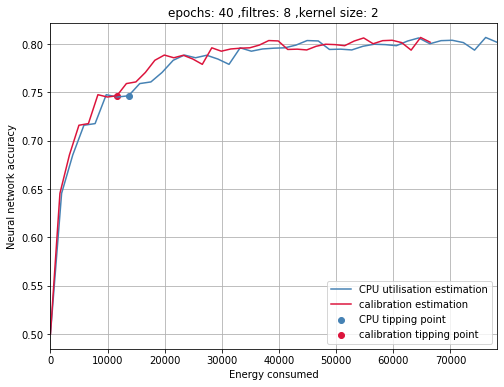

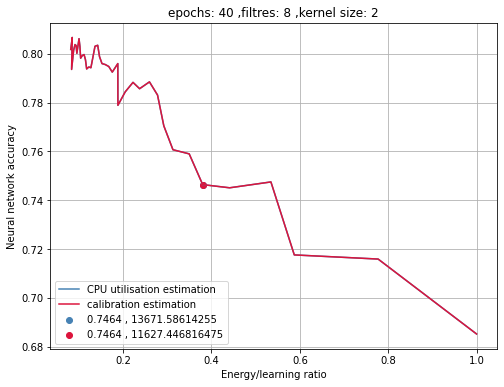

In [147]:
generate("40_8_2");

Kernel size 3 and 8 filters.


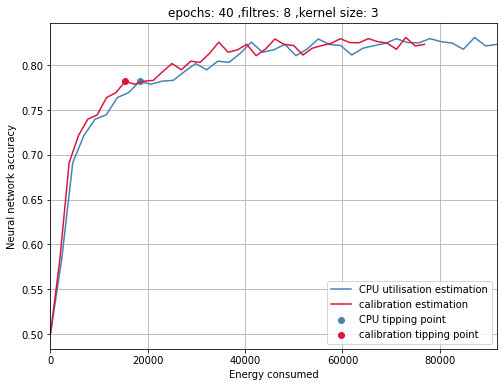

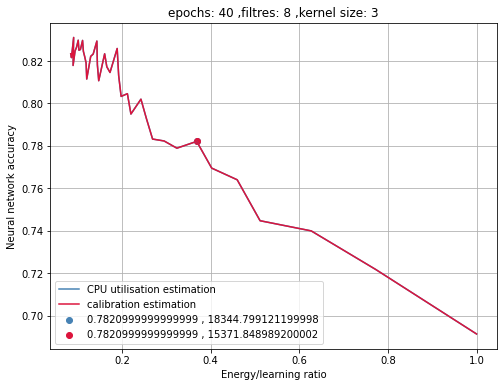

In [148]:
generate("40_8_3");

Kernel size 4 and 8 filters.


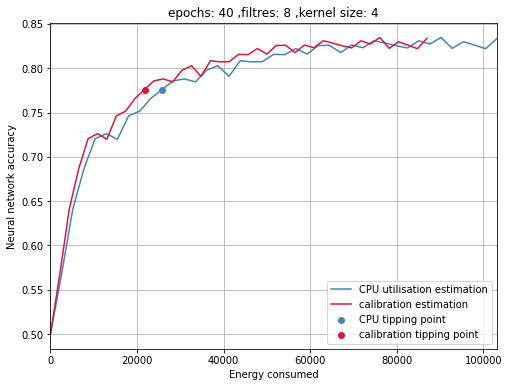

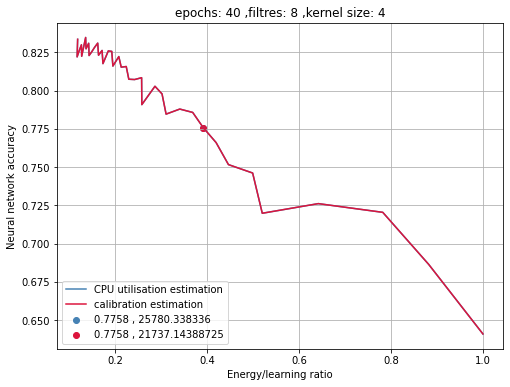

In [149]:
generate("40_8_4");

Kernel size 2 and 16 filters.


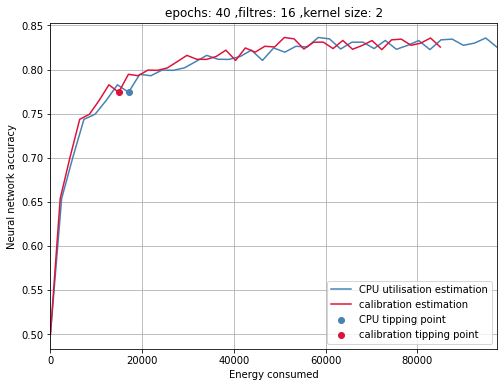

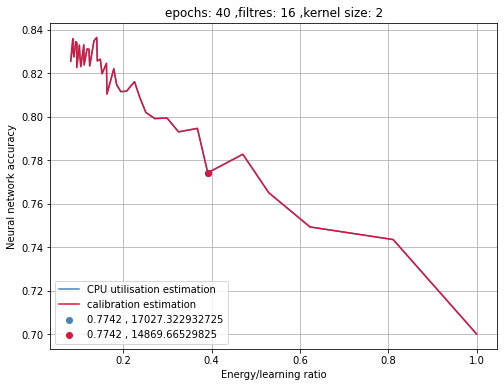

In [150]:
generate("40_16_2");

Kernel size 3 and 16 filters.


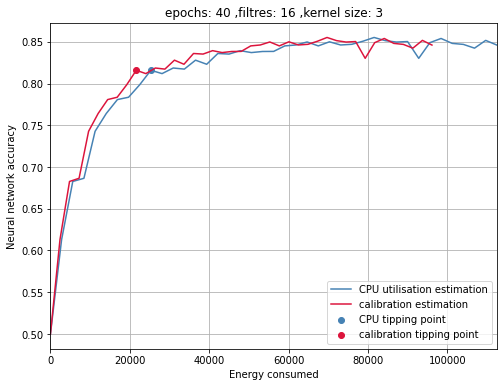

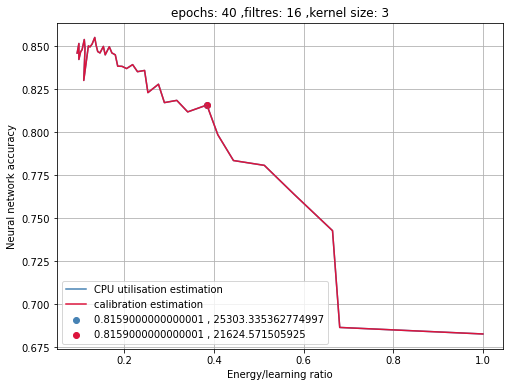

In [151]:
generate("40_16_3");

Kernel size 4 and 16 filters.


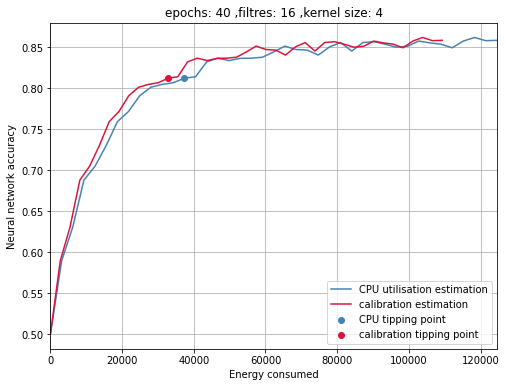

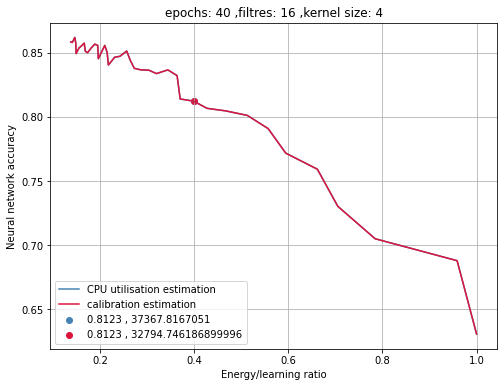

In [152]:
generate("40_16_4");

Kernel size 2 and 32 filters.


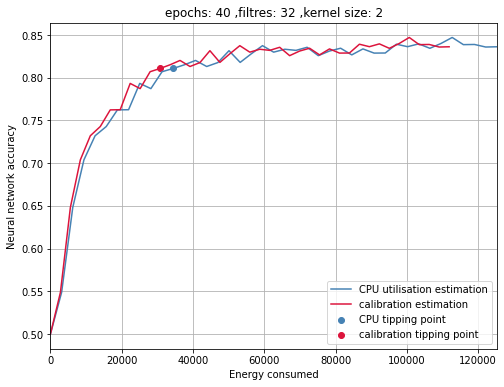

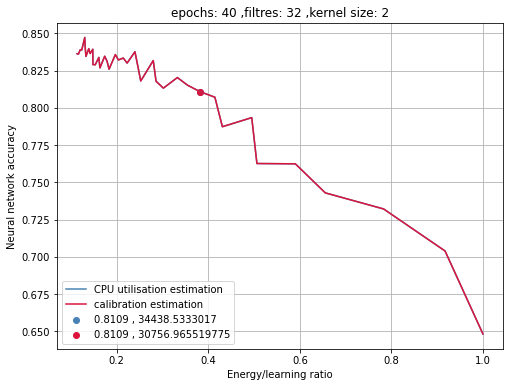

In [153]:
generate("40_32_2");

Kernel size 3 and 32 filters.


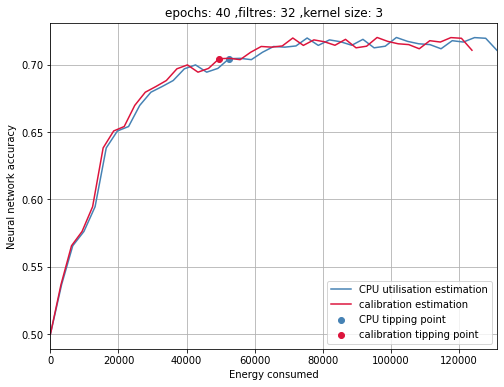

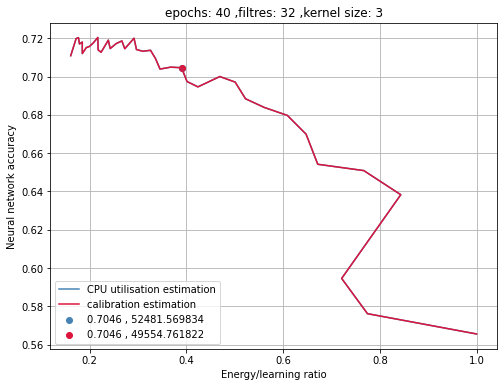

In [154]:
generate("40_32_3");

Kernel size 4 and 32 filters.


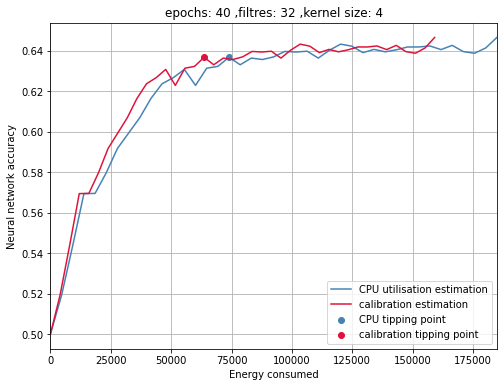

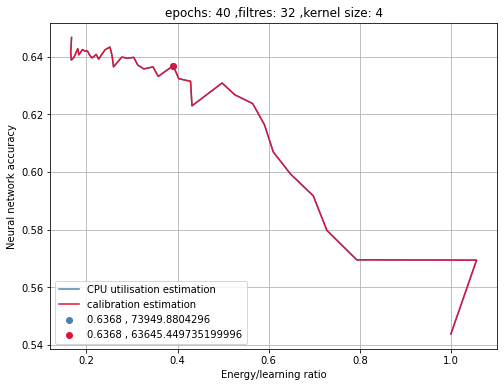

In [157]:
generate("40_32_4");